# Angular Reflectance Spectrum of a Planar Interface with Bfast 

This provides an example of how to use the bfast feature. The reflectance spectrum of a planar interface is obtained first using bfast and then by using Bloch periodic boundary conditions to allow a comparison.  

Below is the function to calculate the spectrum using bfast.

In [6]:
import meep as mp
import math
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

resolution = 50  # pixels/um

dpml = 1.0  # PML thickness
sz = 10 + 2 * dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(thickness=dpml,direction=mp.Z)]

wvl_min = 0.4  # min wavelength
wvl_max = 0.8  # max wavelength
fmin = 1 / wvl_max  # min frequency
fmax = 1 / wvl_min  # max frequency
fcen = 0.5 * (fmin + fmax)  # center frequency
df = fmax - fmin  # frequency width
nfreq = 50  # number of frequency bins


def planar_reflectance(theta):
    # rotation angle (in degrees) of source: CCW around Y axis, 0 degrees along +Z axis
    theta_r = math.radians(theta)

    # plane of incidence is XZ; rotate counter clockwise (CCW) about y-axis

# if normal incidence, force number of dimensions to be 1
    if theta_r == 0:
        dimensions = 1
    else:
        dimensions = 3

    sources = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ex,
            center=mp.Vector3(z=-0.5 * sz + dpml),
        )
    ]
    if theta > 40: #needs to be lower for stability
        Courant = 0.05
    else:
        Courant = 0.1

    sim = mp.Simulation(
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        dimensions=dimensions,
        resolution=resolution,
        bfast_scaled_k = (np.sin(theta_r),0,0), #sets the angle of the incident wave
        Courant = Courant 
    )

    refl_fr = mp.FluxRegion(center=mp.Vector3(z=-0.25 * sz))
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ex, mp.Vector3(z=-0.5 * sz + dpml), 1e-9
        )
    )

    empty_flux = mp.get_fluxes(refl)
    empty_data = sim.get_flux_data(refl)

    sim.reset_meep()

    # add a block with n=3.5 for the air-dielectric interface
    geometry = [
        mp.Block(
            mp.Vector3(mp.inf, mp.inf, 0.5 * sz),
            center=mp.Vector3(z=0.25 * sz),
            material=mp.Medium(index=3.5),
        )
    ]

    sim = mp.Simulation(
        cell_size=cell_size,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        dimensions=dimensions,
        resolution=resolution,
        bfast_scaled_k = (np.sin(theta_r),0,0),
        Courant = Courant  
    )

    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    sim.load_minus_flux_data(refl, empty_data)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ex, mp.Vector3(z=-0.5 * sz + dpml), 1e-9
        )
    )

    refl_flux = mp.get_fluxes(refl)
    freqs = mp.get_flux_freqs(refl)

    wvls = np.empty(nfreq)
    R = np.empty(nfreq)
    for i in range(nfreq):
        wvls[i] = 1 / freqs[i]
        R[i] = -refl_flux[i] / empty_flux[i]
        print("refl:, {}, {}, {}".format(wvls[i], theta, R[i]))
    
    return wvls, theta, R

This is the same function but using Bloch periodic boundaries.

In [2]:
def planar_reflectance_original(theta):
    # rotation angle (in degrees) of source: CCW around Y axis, 0 degrees along +Z axis
    theta_r = math.radians(theta)

    # plane of incidence is XZ; rotate counter clockwise (CCW) about y-axis
    k = mp.Vector3(z=fmin).rotate(mp.Vector3(y=1), theta_r)

    # if normal incidence, force number of dimensions to be 1
    if theta_r == 0:
        dimensions = 1
    else:
        dimensions = 3

    sources = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ex,
            center=mp.Vector3(z=-0.5 * sz + dpml),
        )
    ]
    sim = mp.Simulation(
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=k,
        dimensions=dimensions,
        resolution=resolution,
    )

    refl_fr = mp.FluxRegion(center=mp.Vector3(z=-0.25 * sz))
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ex, mp.Vector3(z=-0.5 * sz + dpml), 1e-9
        )
    )

    empty_flux = mp.get_fluxes(refl)
    empty_data = sim.get_flux_data(refl)

    sim.reset_meep()

    # add a block with n=3.5 for the air-dielectric interface
    geometry = [
        mp.Block(
            mp.Vector3(mp.inf, mp.inf, 0.5 * sz),
            center=mp.Vector3(z=0.25 * sz),
            material=mp.Medium(index=3.5),
        )
    ]

    sim = mp.Simulation(
        cell_size=cell_size,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=k,
        dimensions=dimensions,
        resolution=resolution,
    )

    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    sim.load_minus_flux_data(refl, empty_data)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ex, mp.Vector3(z=-0.5 * sz + dpml), 1e-9
        )
    )
    refl_flux = mp.get_fluxes(refl)
    freqs = mp.get_flux_freqs(refl)

    wvls = np.empty(nfreq)
    theta_out = np.empty(nfreq)
    R = np.empty(nfreq)
    for i in range(nfreq):
        wvls[i] = 1 / freqs[i]
        theta_out[i] = math.degrees(math.asin(k.x / freqs[i]))
        R[i] = -refl_flux[i] / empty_flux[i]
        print("refl:, {}, {}, {}, {}".format(k.x, wvls[i], theta_out[i], R[i]))

    return k.x * np.ones(nfreq), wvls, theta_out, R


The reflectance spectrum is then calculated for a range of angles between 0 and 50 degrees.

In [3]:
theta_in = np.arange(0, 55, 5)
wvl = np.empty(nfreq)
thetas = np.empty((nfreq, theta_in.size))
Rmeep = np.empty((nfreq, theta_in.size))

for j in range(theta_in.size):
    wvl, thetas[:, j], Rmeep[:, j] = planar_reflectance(theta_in[j])

-----------
Initializing structure...
time for choose_chunkdivision = 0.000143223 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 12 with resolution 50
time for set_epsilon = 0.000574305 s
-----------
field decay(t = 50.002): 0.2535922222197771 / 0.2535922222197771 = 1.0
field decay(t = 100.004): 3.242069433496442e-17 / 0.2535922222197771 = 1.2784577559664604e-16
run 0 finished at t = 100.004 (50002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000176516 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 12 with resolution 50
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.000425481 s
-----------
field decay(t = 50.002): 0.25359222221929495 / 0.25359222221929495 = 1.0
field decay(t = 100.004): 1.7974784816283913e-11 / 0.25359222221929495 = 7.088066289643592e-11
run 0 finished at t = 100.0

Using the original function requires a wider range of input angles in order to fill more of the space, due to the frequency dependence of the angle. 

In [8]:
theta_in_orig = np.arange(0, 85, 5)
wvl_orig = np.empty(nfreq)
kxs_orig = np.empty((nfreq, theta_in_orig.size))
thetas_orig = np.empty((nfreq, theta_in_orig.size))
Rmeep_orig = np.empty((nfreq, theta_in_orig.size))

for j in range(theta_in_orig.size):
    kxs_orig[:, j], wvl_orig, thetas_orig[:, j], Rmeep_orig[:, j] = planar_reflectance_original(theta_in_orig[j])

-----------
Initializing structure...
time for choose_chunkdivision = 0.000157701 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 12 with resolution 50
time for set_epsilon = 0.000531193 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.25332329653323415 / 0.25332329653323415 = 1.0
field decay(t = 100.01): 6.806395978139866e-16 / 0.25332329653323415 = 2.686841704370019e-15
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.6404e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 12 with resolution 50
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.000504612 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.25332329652480207 / 0.25332329652480207 = 1.0
field decay(t = 100.01): 1.9736380723733672e-11 / 0.25332329652480207

The reflectance spectra from the 2 different functions are compared below at fixed wavelengths. The two functions agree closely.

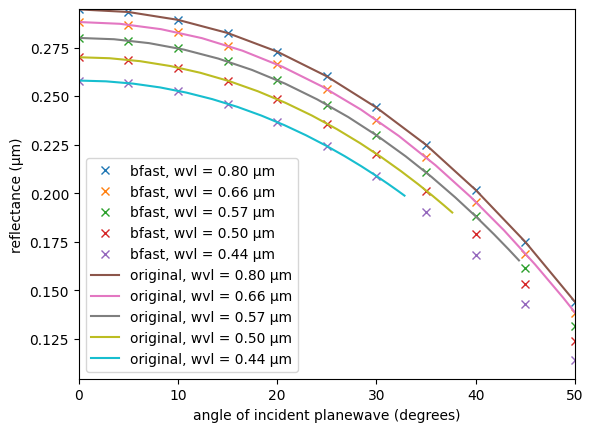

In [9]:
for i in range(0,len(wvl),10):
    lbl = "bfast, wvl = %.2f μm"%wvl[i]
    plt.plot(thetas[i,:],Rmeep[i,:],'x',label=lbl)
for i in range(0,len(wvl),10):
    lbl = "original, wvl = %.2f μm"%wvl[i]
    plt.plot(thetas_orig[i,:],Rmeep_orig[i,:],label=lbl)
plt.xlabel("angle of incident planewave (degrees)")
plt.ylabel("reflectance (μm)")
plt.axis([theta_in.min(),theta_in.max(), Rmeep.min(), Rmeep.max()])
plt.legend()

The reflectance spectrum for all wavelengths is shown for both functions below. The two plots give the same values however, due to the frequency dependence of the original approach, some of the space is left empty.

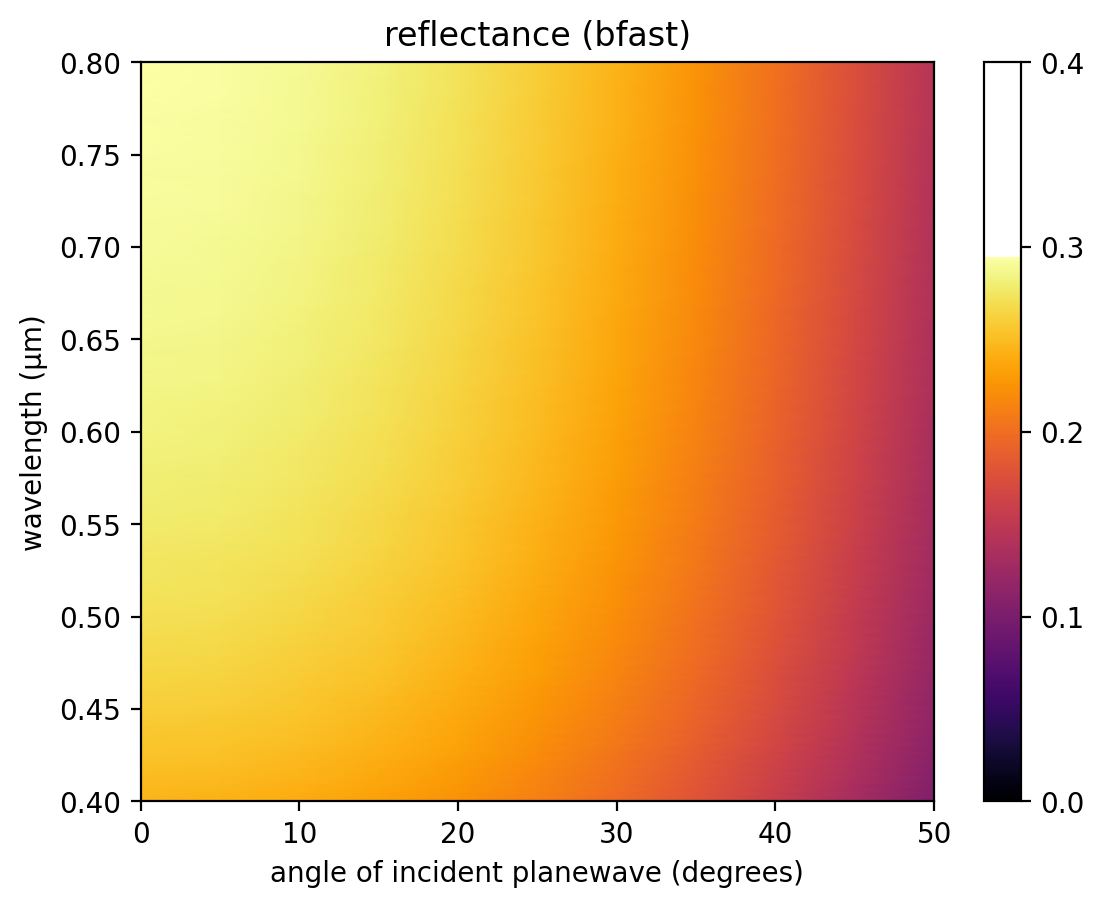

In [7]:
# create a 2d matrix for the wavelength by repeating the column vector for each angle
wvls = np.transpose(np.matlib.repmat(wvl, theta_in.size, 1))

plt.figure(dpi=200)
plt.pcolormesh(
   thetas, wvls, Rmeep, cmap="inferno", shading="gouraud", vmin=0, vmax=Rmeep.max()
)
plt.axis([thetas.min(), thetas.max(), wvl_min, wvl_max])
plt.xlabel("angle of incident planewave (degrees)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (bfast)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.linspace(0, 0.4, 5)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.linspace(0, 0.4, 5)])

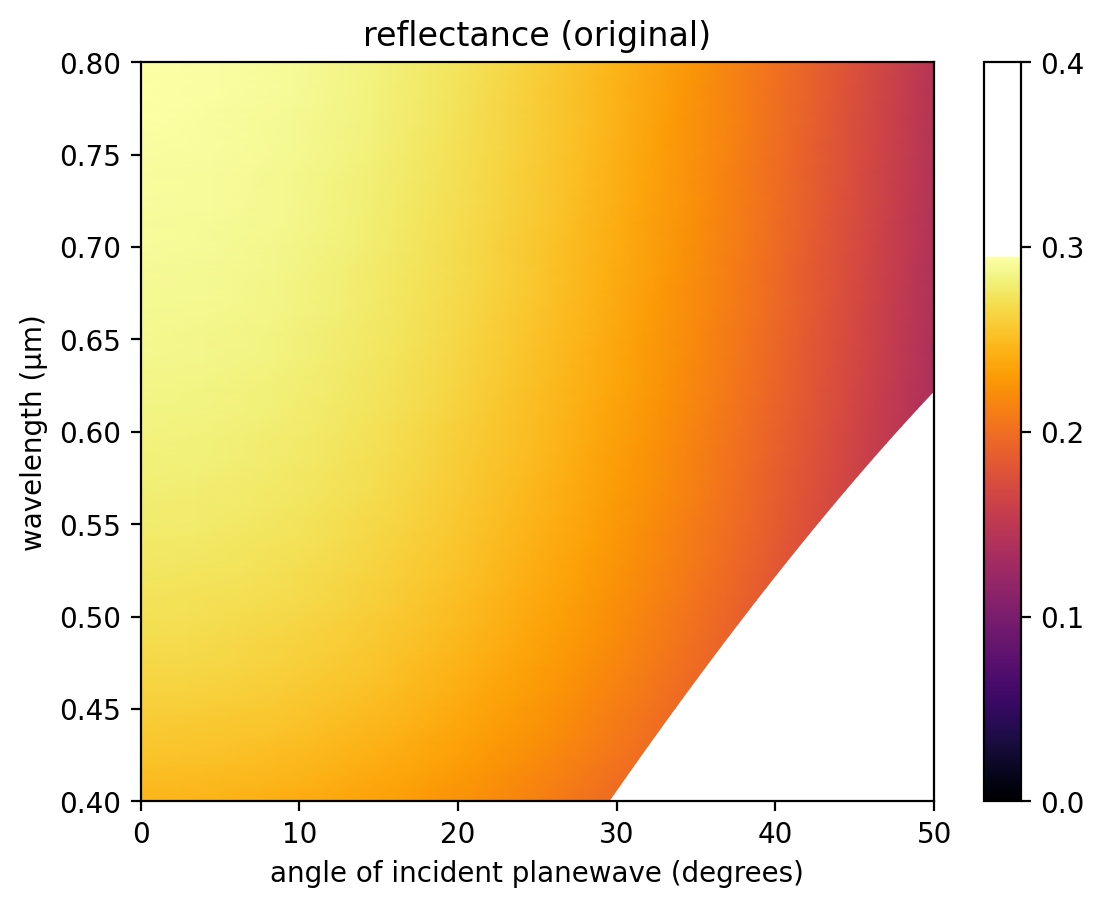

In [10]:
wvls_orig = np.transpose(np.matlib.repmat(wvl_orig, theta_in_orig.size, 1))

plt.figure(dpi=200)
plt.pcolormesh(
   thetas_orig, wvls_orig, Rmeep_orig, cmap="inferno", shading="gouraud", vmin=0, vmax=Rmeep_orig.max()
)
plt.axis([thetas.min(), thetas.max(), wvl_min, wvl_max])
plt.xlabel("angle of incident planewave (degrees)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (original)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.linspace(0, 0.4, 5)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.linspace(0, 0.4, 5)])